# Analise descritiva


[ml map sklearn](https://scikit-learn.org/stable/tutorial/machine_learning_map/)

## Carregar dados tratados

In [70]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [71]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

import joblib

In [72]:
def carregar_joblib():
    df = joblib.load("../out/tratamento_target_col_calc.joblib")
    return df

In [73]:
def print_histograma_comprar_vender(df):
    df['decisao'].value_counts(normalize=True).map("{:.1%}".format)
    fig = px.histogram(df, x="decisao", color="decisao")
    fig.show()

In [74]:
def print_correlacoes(df):

    print("Correlacoes")
    print(df.corr())

    print("--" * 40)
    
    print("Describe")
    print(df.describe())

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df.corr(), cmap="Wistia", annot=True, fmt = '.2f', ax=ax)
    plt.show()

In [95]:
def remover_variaveis_ja_explicadas(df, best_features):
    # todas as colunas: ['RPL', 'ROE', 'AF', 'RA', 'part_cap_terceiros', 'comp_endividamento',
    #   'imob_patrimonio_liq', 'imob_recursos_n_corr', 'liq_corrente',
    #   'decisao']

    # remover = ["RPL", "RA", "AF", "GA"] # RN
    # remover = ["RPL", "RA", "part_cap_terceiros"] # RN
    # ['AF', 'part_cap_terceiros', 'imob_patrimonio_liq'] ficar cols - selectkbest
    # remover = ["RPL", "ROE", "RA", "liq_corrente", "comp_endividamento", "imob_recursos_n_corr"] # selectkbest
    to_remove = set(best_features) ^ set(df.columns)
    to_remove.remove('decisao')
    print("Colunas a remover do df original: ", to_remove)
    df = df.drop(to_remove, axis=1)

    return df

## P value

In [76]:
def print_p_value(df):
    all_col = " + ".join(df.drop("decisao", axis=1).columns)
    model = smf.glm(formula="decisao ~ " + all_col, data=df,
                    family = sm.families.Binomial()).fit()

    print(model.summary()) 

## Feature selection

In [77]:
def print_feature_selection_extra_trees(df):
    modelo = ExtraTreesClassifier(random_state=1)
    x = df.drop("decisao", axis=1)
    y = df["decisao"]
    modelo.fit(x, y)

    caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
    print(caracteristicas_importantes)

In [78]:
def print_feat_sel_select_k_best(df):
    X = df.drop("decisao", axis=1)
    y = df["decisao"]

    select_percentile = SelectPercentile(score_func=f_classif, percentile=30)

    select = SelectKBest(score_func=f_classif, k=4)

    X_new = select_percentile.fit_transform(X, y)
    print(X_new.shape)
    
    z = select.fit(X, y)

    filter = select.get_support()
    
    print("Selected best 3:")
    print(X.columns[filter])
    return list(X.columns[filter])


In [79]:
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    
    return tabela_auxiliar


In [80]:
def salvar_df_in_joblib(df, file_name: str = "../out/result_analise_desc.joblib"):

    joblib.dump(df, file_name)

    print("arquivo joblib de df analise descritiva criado com sucesso")


# Execucao

(1667, 9)
Index(['ativo_total', 'ativo_permanente', 'ativo_circ', 'passivo_circ',
       'passivo_nao_circ', 'patrimonio_liq', 'receita_liq', 'lucro_op',
       'decisao'],
      dtype='object')
Correlacoes
                  ativo_total  ativo_permanente  ativo_circ  passivo_circ  \
ativo_total          1.000000          0.269509    0.429729      0.535325   
ativo_permanente     0.269509          1.000000   -0.019850      0.121006   
ativo_circ           0.429729         -0.019850    1.000000      0.411549   
passivo_circ         0.535325          0.121006    0.411549      1.000000   
passivo_nao_circ     0.507739          0.170927    0.093626      0.071446   
patrimonio_liq       0.140340          0.010950    0.063121     -0.002234   
receita_liq          0.054845          0.306268    0.013716      0.016168   
lucro_op            -0.011142          0.027720    0.010221     -0.056626   
decisao              0.044458         -0.010255    0.054972      0.021678   

                  pass

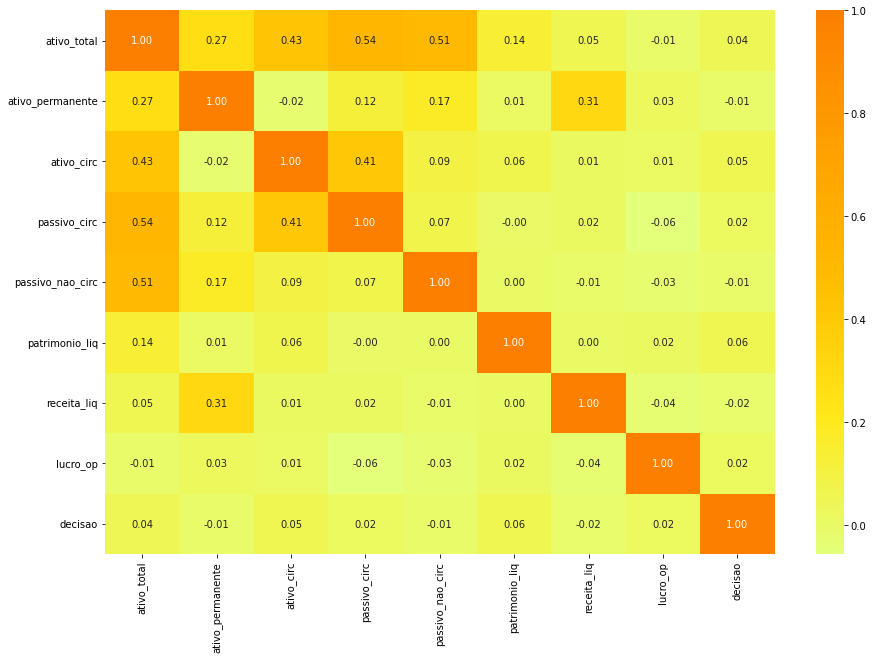

                 Generalized Linear Model Regression Results                  
Dep. Variable:                decisao   No. Observations:                 1667
Model:                            GLM   Df Residuals:                     1658
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1147.7
Date:                Thu, 21 Oct 2021   Deviance:                       2295.3
Time:                        22:23:21   Pearson chi2:                 1.66e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.009294
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0377      0.052  

In [98]:
def main():
    df = carregar_joblib()

    print(df.shape)
    print(df.columns)

    # print_histograma_comprar_vender(df)

    print_correlacoes(df)

    print_p_value(df)
    return
    # print("Feature Selection")

    best_features = print_feat_sel_select_k_best(df)

    df = remover_variaveis_ja_explicadas(df, best_features)

    print(df.columns)

    df = ajustar_scaler(df)

    print("Correlacoes apos remover algumas colunas")

    print_correlacoes(df)

    print("#-" * 40)

    print_p_value(df)

    # print(df.shape)

    # print_feature_selection_extra_trees(df)

    # salvar_df_in_joblib(df, "../out/result_analise_desc.joblib")


    # print_correlacoes(df)

    salvar_df_in_joblib(df, "../out/result_analise_desc_scaled.joblib")

    return df

    
df = main()

In [ ]:
df.describe()

,ROE,AF,comp_endividamento,imob_patrimonio_liq,imob_recursos_n_corr,liq_corrente,decisao
count,1667.000000,1.667000e+03,1.667000e+03,1.667000e+03,1.667000e+03,1.667000e+03,1667.000000
mean,0.000000,-8.524808e-18,2.557442e-17,-1.704962e-17,2.770563e-17,-1.758242e-17,0.497301
std,1.000300,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,0.500143
min,-0.431999,-1.299419e+01,-4.257807e+00,-8.986001e+00,-3.172033e+00,-3.370813e+00,0.000000
25%,-0.042910,-1.824811e-01,-4.610625e-01,-2.650163e-01,-2.537201e-01,-4.504053e-01,0.000000
50%,-0.038158,-8.131200e-02,-3.746429e-02,-1.039398e-01,-9.039397e-02,-1.091690e-01,0.000000
75%,-0.030857,4.478989e-02,3.522806e-01,9.256320e-02,8.732894e-02,2.910041e-01,1.000000
max,38.307571,1.727017e+01,7.414332e+00,1.231565e+01,2.505584e+01,1.045639e+01,1.000000


In [ ]:
df.describe()

,ROE,AF,comp_endividamento,imob_patrimonio_liq,imob_recursos_n_corr,liq_corrente,decisao
count,1667.000000,1.667000e+03,1.667000e+03,1.667000e+03,1.667000e+03,1.667000e+03,1667.000000
mean,0.000000,-8.524808e-18,2.557442e-17,-1.704962e-17,2.770563e-17,-1.758242e-17,0.497301
std,1.000300,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,0.500143
min,-0.431999,-1.299419e+01,-4.257807e+00,-8.986001e+00,-3.172033e+00,-3.370813e+00,0.000000
25%,-0.042910,-1.824811e-01,-4.610625e-01,-2.650163e-01,-2.537201e-01,-4.504053e-01,0.000000
50%,-0.038158,-8.131200e-02,-3.746429e-02,-1.039398e-01,-9.039397e-02,-1.091690e-01,0.000000
75%,-0.030857,4.478989e-02,3.522806e-01,9.256320e-02,8.732894e-02,2.910041e-01,1.000000
max,38.307571,1.727017e+01,7.414332e+00,1.231565e+01,2.505584e+01,1.045639e+01,1.000000
